In [16]:
from preprocessing import Preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import seaborn as sns
#import pmdarima as pm
from dateutil.relativedelta import relativedelta
import warnings
warnings.simplefilter(action='ignore')
from sklearn.metrics import accuracy_score
import time
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# import fbprophet  # if you have an issue (on your workstation) with fbprophet on python3.8 i would suggest you to use python3.7 instead
# from fbprophet import Prophet
from numpy import median
import math
import statistics

In [10]:
df =pd.read_csv("./data/data/sales_train_validation.csv")
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [11]:
# reading and inserting the calendar csv sheet into Dataframe, this data will be used as lookup to get the right date for each day in df dataframe
calendar = pd.read_csv('./data/calendar.csv')
calendar.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [12]:
df.drop(columns=['item_id', 'dept_id','cat_id','store_id','state_id'],axis=1, inplace=True) # Drop the unnecessary columns
data = df.T  # seting the days as index for new dataframe(Data)
data.columns = df['id'] # ading product id column to Data 
data.index.name = None   # remove the name of index
data.drop(index='id',inplace=True) # remove the first row
# change the format and the freq. of index to datetime format
data.index = calendar['date'][0:1913]
data.index = pd.to_datetime(data.index)
data.index.freq= 'd'
data.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-04-15', '2016-04-16', '2016-04-17', '2016-04-18',
               '2016-04-19', '2016-04-20', '2016-04-21', '2016-04-22',
               '2016-04-23', '2016-04-24'],
              dtype='datetime64[ns]', name='date', length=1913, freq='D')

In [13]:
max_value =data.max().to_frame()
max_prod = max(data.max())
max_value.loc[max_value[0] == max_prod]

,0
id,
FOODS_3_090_CA_3_validation,763


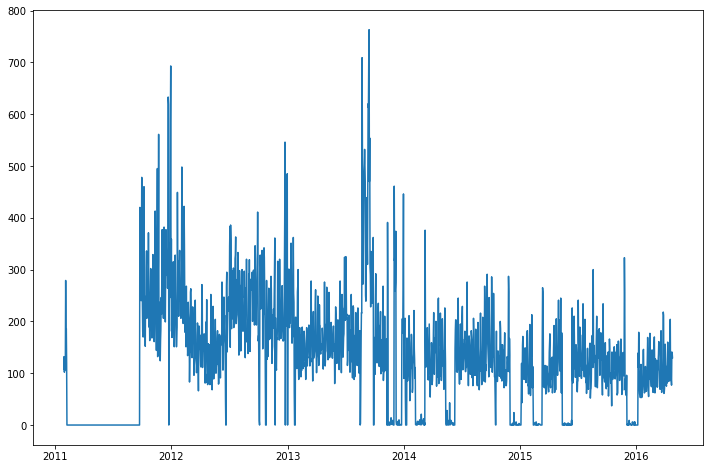

In [15]:
# WE noctice that numbe of purchasments is zero for arround first 10 months which looks justified if product was not linched or avaliable yet in the stores at that time thats why this interval will be ecluded from time series 
plt.figure(figsize=(12,8))
plt.plot(data.index,data['FOODS_3_090_CA_3_validation'])

adf is -9.690404728774492
pvalue is 1.140533081967058e-16


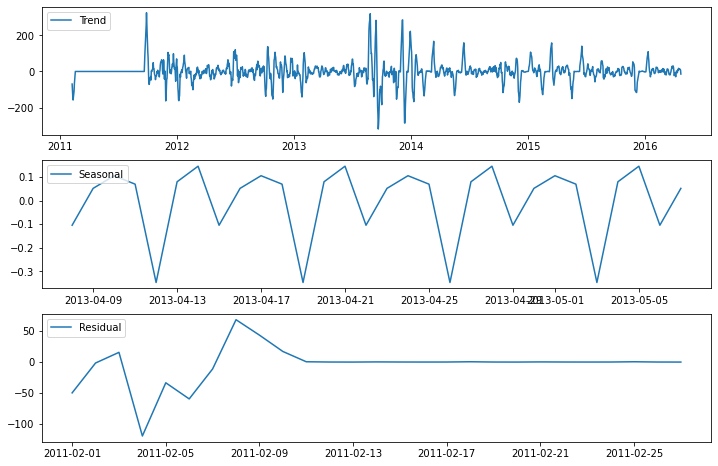

In [18]:
# diffrencing method

data['shift'] = data['FOODS_3_090_CA_3_validation'].shift(7)
data['week_lag'] = data['FOODS_3_090_CA_3_validation'] - data['shift']

ss_decomposition = seasonal_decompose(x=data['week_lag'].dropna())
lag_trend = ss_decomposition.trend
lag_seasonal = ss_decomposition.seasonal
lag_residual = ss_decomposition.resid

#fig, ax = plt.subplots(3,1, figsize=(12,8))
fig, ax = plt.subplots(3,figsize=(12,8) )
#plt.figure(figsize=(12,5))
#plt.subplot(3,1,1)
ax[0].plot(data.index[7:],lag_trend, label='Trend')
ax[0].legend(loc='upper left')

#plt.subplot(3,1,2)
ax[1].plot(data.index[800:830],lag_seasonal[800:830], label='Seasonal')
ax[1].legend(loc='upper left')

#plt.subplot(3,1,3)
ax[2].plot(data.index[:30],lag_residual[:30], label='Residual')
ax[2].legend(loc='upper left')

adf_dif, pvalue_dif,usedlag, nobs, critical_values, icbest = adfuller(data['week_lag'].dropna())

print(f'adf is {adf_dif}')
print(f'pvalue is {pvalue_dif}')